# Радарные графики по дням

In [27]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm, rc
%matplotlib inline
from alex.database import Database
import time
from datetime import datetime

## Загрузка данных

In [152]:
# загрузка истории
# 20 секунд
start = time.time()
db = Database()
# sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-07-01'"
sql_history = f"select dt, price, amount, side from v_history " \
              f"where id_ex_pair=19 and dt>'2018-07-01' order by dt"
              #f"and location='memory'" \
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)
df_history.index = pd.to_datetime(df_history.index)
df_history.side = df_history.side.astype('category')
print(f"Loading time: {time.time()-start:.02f} sec")

Loading time: 20.38 sec


In [153]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4418145 entries, 2018-08-07 03:18:34 to 2018-10-25 00:10:06
Data columns (total 3 columns):
price     float64
amount    float64
side      category
dtypes: category(1), float64(2)
memory usage: 105.3 MB


In [154]:
df_history.shape # (4329127, 11)

(4418145, 3)

In [155]:
df_history.tail()

,price,amount,side
dt,,,
2018-10-25 00:10:05,205.899994,0.10100,buy
2018-10-25 00:10:05,205.850006,0.45779,sell
2018-10-25 00:10:06,205.850006,1.02600,sell
2018-10-25 00:10:06,205.860001,0.15987,sell
2018-10-25 00:10:06,205.860001,0.32563,sell


## Функции рисования

In [477]:
def single_radar(categories, values, heading='', color='r'):
    N = len(categories)
    angles = [n/float(N) * 2 * np.pi for n in range(N)]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    minval, maxval = np.min(values), np.max(values)
    yticks = [int(y) for y in np.arange(minval-1, maxval+1, step=1.0)]
    
    if heading!='':
        ax.set_title(heading, loc='left', size=15, color=color, fontweight='bold')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(angles)          # установка кол-ва углов, соответстующих кол-ву дней в неделе
    ax.set_xticklabels(categories) # надписи дней недели
    ax.set_rlabel_position(90)     # цены распологаю вертикально, чтоб не пересекались с осями
    ax.set_ylim(minval-1, maxval+1)

    ax.fill(angles[:len(values)], values, color=color, alpha=0.2)
    ax.plot(angles[:len(values)], values, color=color, linewidth=2, linestyle='solid', marker='o')
    plt.show()

In [475]:
def radar_price_amount(categories, prices, amounts=None, heading='', price_color='r', amount_color='b'):
    N = len(categories)
    angles = [n/float(N) * 2 * np.pi for n in range(N)]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    minval, maxval = np.min(prices), np.max(prices)
    yticks = [int(y) for y in np.arange(minval-1, maxval+1, step=1.0)]
    
    if heading!='':
        ax.set_title(heading, loc='left', size=15, color=price_color, fontweight='bold')
        
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(angles)          # установка кол-ва углов, соответстующих кол-ву дней в неделе
    ax.set_xticklabels(categories) # надписи дней недели
    ax.set_rlabel_position(0)     # цены распологаю вертикально, чтоб не пересекались с осями
    ax.set_ylim(minval-1, maxval+1)
    ax.set_yticklabels(yticks, color=price_color)

    ax.fill(angles[:len(prices)], prices, price_color, alpha=0.2)
    plot1 = ax.plot(angles[:len(prices)], prices, price_color, linewidth=2, linestyle='solid', marker='o', label='price')
    
    # включение второй полярной оси на том же графике для отображения amount
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    
    # крашу ось с суммами
    ax2.tick_params(colors=amount_color)
    ax2.set_rlabel_position(45)     # цены распологаю вертикально, чтоб не пересекались с осями
    
    # рисуем amount
    plot2 = ax2.plot(angles[:len(amounts)], amounts, amount_color, linewidth=2, linestyle='solid', marker='o', label='amount')
    ax2.fill(angles[:len(amounts)], amounts, amount_color, alpha=0.1)
    
    # выводим легенду (workaround для polar plots)
    lns = plot1 + plot2
    labels = [l.get_label() for l in lns]
    ax.legend(lns, labels, loc=1)
    
    plt.show()

## Препроцессинг

In [449]:
# группирую исходные данные по часам. Цены беру медианные, а суммы складываю.
hours = df_history[df_history.index>='2018-08'][
    ['price', 'amount']].resample('H').agg({'price':'median', 'amount':'sum'})

# добавляю колонку с номером дня
# hours['day'] = hours.index.day

In [450]:
# проверка на каком-то одном дне
date = '2018-10-18'
hours[date]

,price,amount
dt,,
2018-10-18 00:00:00,212.229996,2738.346274
2018-10-18 01:00:00,213.350006,3316.233151
2018-10-18 02:00:00,213.050003,1545.763959
2018-10-18 03:00:00,212.899994,1905.199825
2018-10-18 04:00:00,212.850006,1931.364168
2018-10-18 05:00:00,212.979996,1807.032704
2018-10-18 06:00:00,214.539993,7920.004700
2018-10-18 07:00:00,214.029999,9503.076647
2018-10-18 08:00:00,213.440002,10274.154902


## Дневной радар

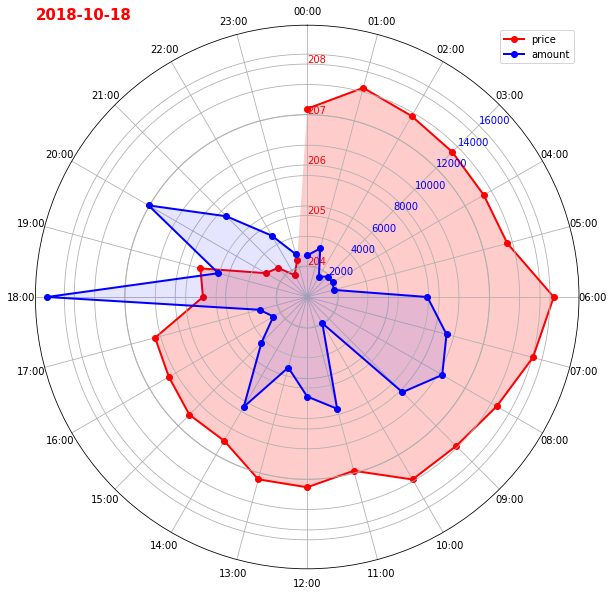

In [476]:
heading = f'{date}'
categories = [f"{x:02d}:00" for x in np.arange(0,24,dtype=int)] # часы в сутках
prices = hours[date].price.values
amounts = hours[date].amount.values

radar_price_amount(categories=categories, prices=prices, amounts=amounts, heading=heading)

## Радары по последним дням

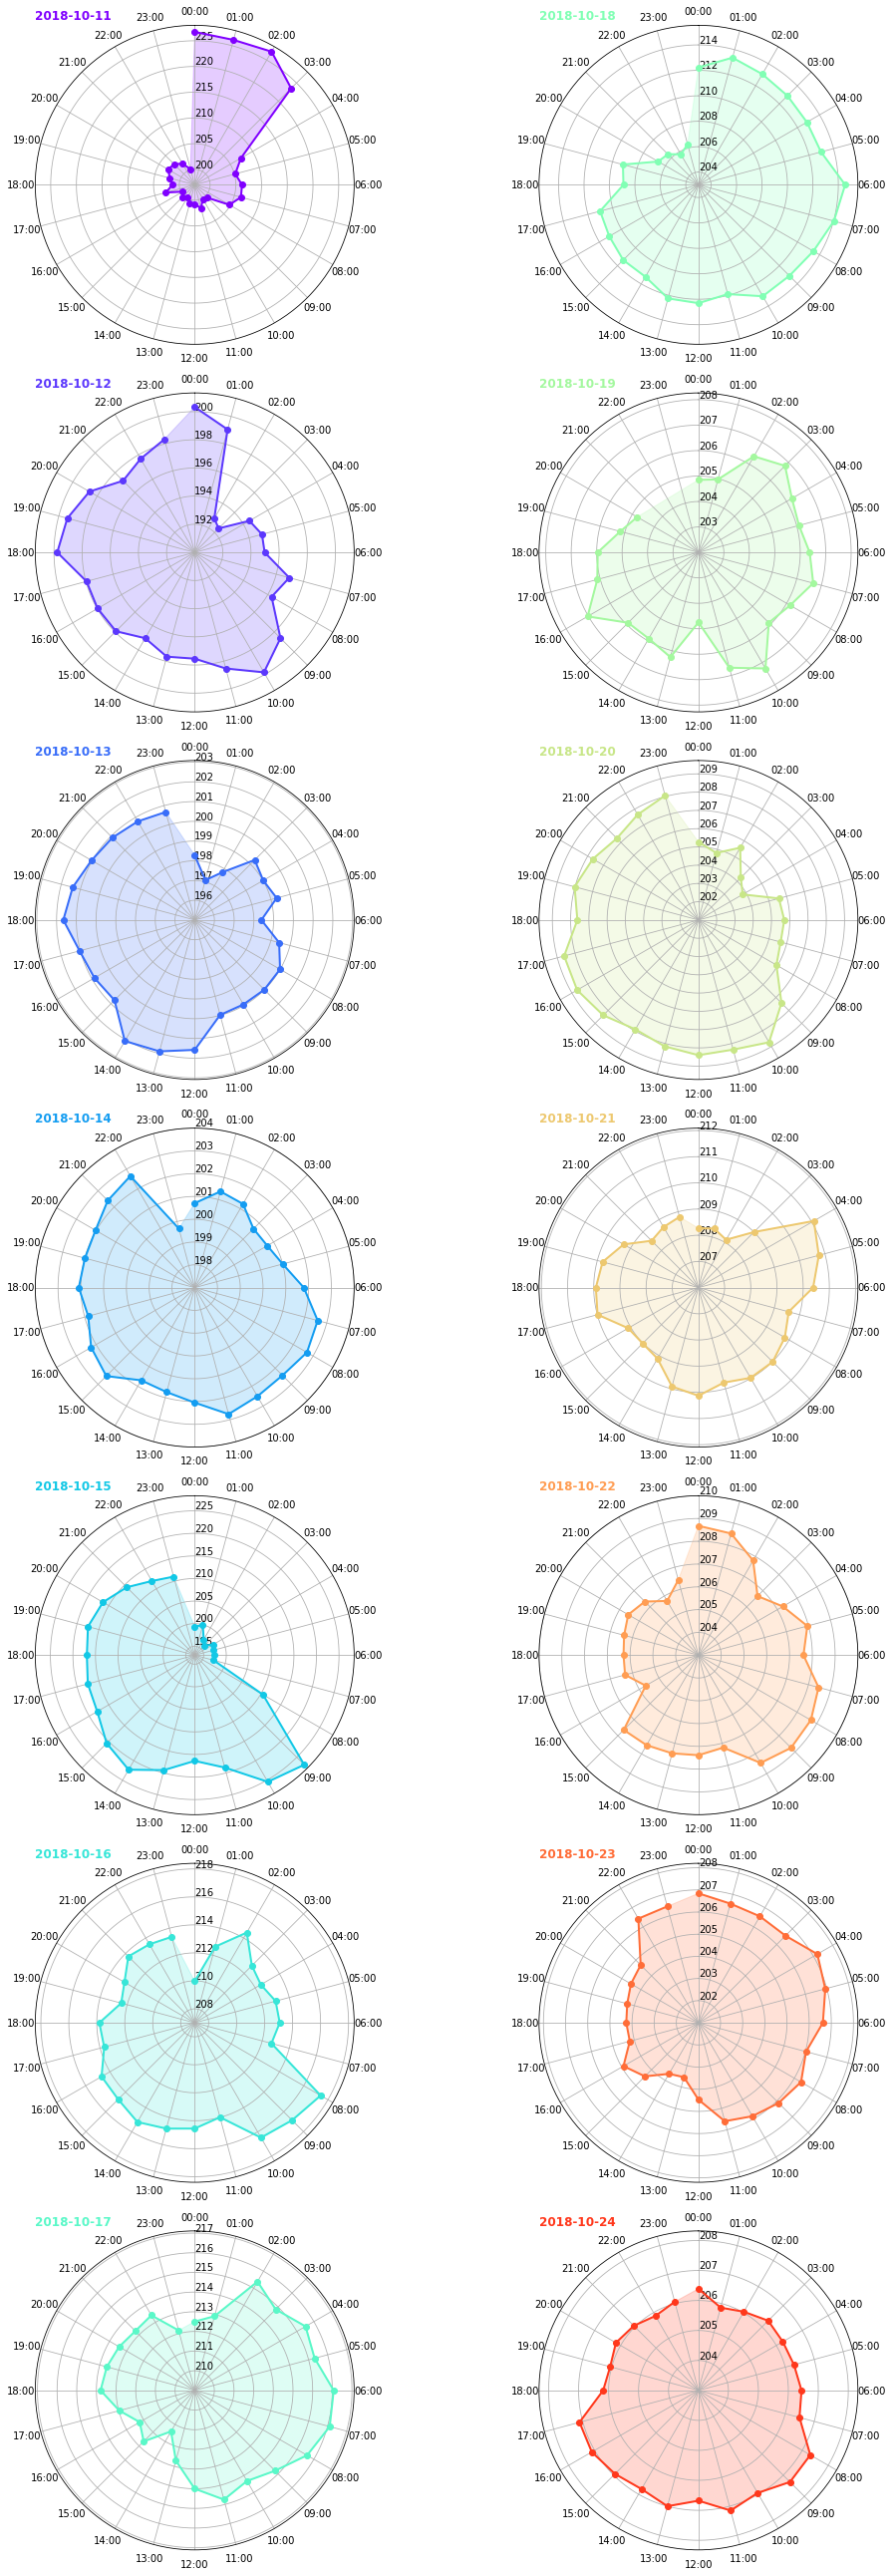

In [490]:
# MULTI-RADAR
columns = 2 # кол-во колонок в графике
subplots_num = 14 # кол-во подграфиков всего (14 последних дней)
figsize=(12, 36)

dt = hours.index[-1] - pd.to_timedelta(f"{subplots_num}day") # вычисляем 14 дней назад от последней даты
dfs = hours[dt.strftime("%Y-%m-%d"):].dropna() # Фильтрую данные от рассчитанной даты и вперёд

# создаём итератор цветов. Цвета берем из радуги, которую делим на кол-во графиков
colors = iter(cm.rainbow(np.linspace(0, 1, len(dfs.resample("D").sum().index.unique()))))

# дни недели
categories = [f"{x:02d}:00" for x in np.arange(0,24,dtype=int)] # часы в сутках
N = len(categories)
angles = [n/float(N) * 2 * np.pi for n in range(N)]

rows = int(np.ceil(len(dfs.index.day.unique())/columns))-1 # кол-во строк в графике
fig, axs = plt.subplots(rows, columns, 
                        subplot_kw=dict(projection='polar'), figsize=figsize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)

x, y = 0, 0 # координаты каждого из рисунков

for interval in dfs.resample("D").sum().index.strftime("%Y-%m-%d"):
    
    df = dfs[interval]
    values = df.price.values

    minval, maxval = np.min(values), np.max(values)
    yticks = [int(y) for y in np.arange(minval-2, maxval+2, step=1.0)]

    color = next(colors) # ротация цветов
    
    ax = axs[x, y]
    ax.set_title(f'{interval}', loc='left', size=12, color=color, fontweight='bold')
    ax.set_xticks(angles)          # установка кол-ва углов, соответстующих кол-ву дней в неделе
    ax.set_xticklabels(categories) # надписи часов
    ax.set_rlabel_position(0)     # цены распологаю вертикально, чтоб не пересекались с осями
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)    
    ax.set_ylim(minval-1, maxval+1)
    ax.set_yticks(yticks, minor=True)
    #ax.set_yticklabels(color='gray')

    ax.fill(angles[:len(values)], values, color=color, alpha=0.2)
    ax.plot(angles[:len(values)], values, color=color, linewidth=2, linestyle='solid', marker='o')
    
    if x<rows-1:
        x+=1
    else:
        if y<columns-1:
            x=0
            y+=1
        else:
            break

# удаляем пустые графики
# empty_plots = rows*cols - len(dfs.index.day.unique())
# if empty_plots>0:
#     fig.delaxes(axs.flatten()[-empty_plots])

fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()